In [3]:
# -*- coding: utf-8 -*-
import numpy as np
from numpy import exp,pi,sqrt,cos,sin
from numpy.fft import *
from scipy.interpolate import RegularGridInterpolator as interpolate
import time
import matplotlib.pyplot as plt
#from mayavi import mlab as m

In [4]:
def Kick2d(cf,ikx,iky,verbose=False):
    """Calculates a Gaussian random field from the squareroot of the 
       Fourier components of the correlation functions (cf) and returns
       the field and its derivatives in x an y direction.The derivatives are 
       calculated using the ikx and iky arguements, which are the 
       wave vecotors multiplied by the imaginary unit.
       
       Returns: U,Fx,Fy
    """   
    phase=(2*np.random.rand(*cf.shape)-1)*pi
    nx=cf.shape[0]
    ny=cf.shape[1]
   
    
    for i in range(0,nx//2):
        for j in range(0,ny):
            phase[(nx-i)%nx ,(ny-j)%ny]=-phase[i,j]
    
    
    phase[0,0]=0
    phase[nx//2,0]=0
    phase[0,ny//2]=0
    phase[nx//2,ny//2]=0
    
    
    cf*=exp(1.j*phase)
    cf[0,0]=0
    
    N=sqrt(nx*ny)
    u=N*ifft2(cf)
    Fx=N*ifft2(ikx*cf)
    Fy=N*ifft2(iky*cf)

    if verbose:    
        print('Max. Im.',np.max(np.abs(np.imag(u))))
        print('mean',np.mean(u))
        print('std',s)
        
    u=np.real(u)
    s=np.std(u)
    return u,np.real(Fx),np.real(Fy)
    
    
def grid(Nx,Ny,Lx=1,Ly=1,x0=0,y0=0):
    return np.meshgrid((np.arange(Nx)/(1.0*Nx)-0.5)*Lx+x0,(np.arange(Ny)/(1.0*Ny)-0.5)*Ly+y0)
    
def gauss(x,y,lc):
    return exp(-(x*x+y*y)/lc**2)    


def gaussani(x,y,lc,a=1,b=1,p=0):
    Mx=(a*cos(p))**2+(b*sin(p))**2
    My=(a*sin(p))**2+(b*cos(p))**2
    Mxy=2*(a**2-b**2)*sin(p)*cos(p)
   
    return exp(-(Mx*x*x+My*y*y+Mxy*x*y)/lc**2)    


computation time: 19.8876 s
calculating histogram time: 1.31088 s


<ipython-input-5-f0643003b087>:65: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(1.5)


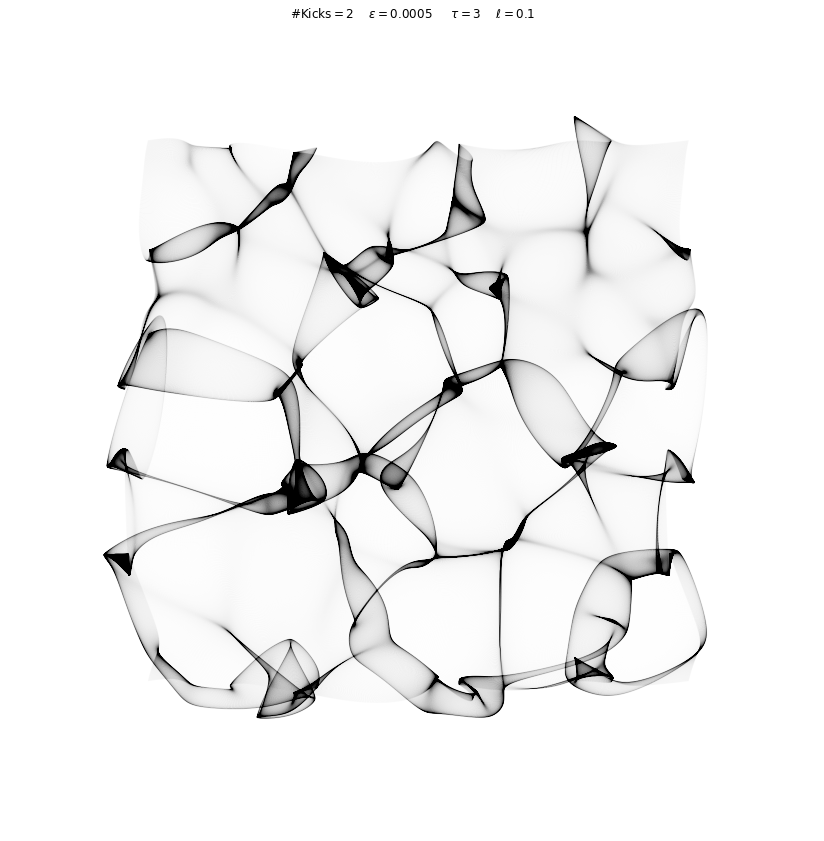

In [5]:

        
      Ng=1024*2  # Number of gridpoints for Kick 
      Nin=1024*4	 # Number of gridpoints for initial conditions
      Nim=2000  # Number of Pixels in histogram
      NK=2 #Number of Kicks
      eps=5e-4  # Kick strength
      tau=3 # time between kicks
      ell=0.1 #Correlation length should not be larger than approx 0.1
    
      xg,yg=grid(Ng,Ng) # this is a grid ranging from -0.5 to 0.5 in both directions
      #c=gaussani(xg,yg,0.1,b=2)
      c=gauss(xg,yg,ell)
      k=np.roll(np.arange(-Ng/2+1,Ng/2+1,dtype="double"),-Ng//2+1)*2*np.pi
      one=np.ones(Ng)
      kx=1.j*np.outer(k,one)
      ky=1.j*np.outer(one,k)
    
      xg+=0.5 # this is just to save some shifts later
      yg+=0.5 
      f=fft2(ifftshift(c))
      cf=eps*complex(1,0)*sqrt(f)
     
      x,y=grid(Nin,Nin,x0=0.5,y0=0.5)
      x=x.flatten()
      y=y.flatten()
      r=np.zeros((Nin*Nin,2)) # The interploation routine likes this
      r[:,0]=x
      r[:,1]=y
      px=np.zeros(Nin*Nin)
      py=np.zeros(Nin*Nin)
      Fx=np.zeros((Ng+1,Ng+1))
      Fy=np.zeros((Ng+1,Ng+1))
      xi=np.append(xg[0,:],[1])
      yi=np.append(yg[:,0],[1])
      
      start_time = time.time()
      
      for t in range(NK):
           U,Fx[0:-1,0:-1],Fy[0:-1,0:-1]=Kick2d(cf,kx,ky)
           Fx[-1,:]=Fx[0,:] # The intepolations does not do periodic B.C.
           Fy[-1,:]=Fy[0,:]
           Fx[:,-1]=Fx[:,0]
           Fy[:,-1]=Fy[:,0]
           Fx[-1,-1]=Fx[0,0]
           Fy[-1,-1]=Fy[0,0]
           Kx=interpolate((xi,yi),Fx)
           Ky=interpolate((xi,yi),Fy)
           px+=Kx(r-np.floor(r))
           py+=Ky(r-np.floor(r))
           r[:,0]+=px*tau
           r[:,1]+=py*tau
      
      stop_time=time.time()      
      print('computation time: %g s'%(stop_time-start_time))
    
    
      dens,xedges,yedges=np.histogram2d(r[:,0],r[:,1],bins=Nim,range=[[-0.25,1.25],[-0.25,1.25]])
      dens/=float(np.max(dens))
      print('calculating histogram time: %g s'%(time.time()-stop_time))
      s=np.std(dens)
      m=np.mean(dens)
      plt.figure(figsize=(12,12),facecolor="w")
      plt.imshow(dens,cmap="Greys",vmax=m+3*s)
      plt.tight_layout(1.5)
      plt.axis("off")
      plt.title(r"#Kicks$=%d$    $\epsilon=%g$     $\tau=%g$    $\ell=%g$"%(NK,eps,tau,ell))
#      plt.figure(figsize=(12,12))
#      plt.plot(r[:,0],r[:,1],'.',markersize=0.25)
#      plt.tight_layout(1.5)
#      plt.axis("off")
#      plt.title(r"#Kicks$=%d$    $\epsilon=%g$     $\tau=%g$    $\ell=%g$"%(NK,eps,tau,ell))
      plt.show()     
